# Point cloud classification with PointNet

**Author:** [David Griffiths](https://dgriffiths3.github.io)<br>
**Date created:** 2020/05/25<br>
**Last modified:** 2020/05/26<br>
**Description:** Implementation of PointNet for ModelNet10 classification.

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Point cloud classification


## Introduction

Classification, detection and segmentation of unordered 3D point sets i.e. point clouds
is a core problem in computer vision. This example implements the seminal point cloud
deep learning paper [PointNet (Qi et al., 2017)](https://arxiv.org/abs/1612.00593). For a
detailed intoduction on PointNet see [this blog
post](https://medium.com/@luis_gonzales/an-in-depth-look-at-pointnet-111d7efdaa1a).


## Setup

If using colab first install trimesh with `!pip install trimesh`.


In [23]:
import sys
# sys.path.insert(1,'/wsu/home/gy/gy40/gy4065/hm.jetscapeml.source')
sys.path.insert(1,'/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.source')

In [25]:
import jet_ml_dataset_builder.jet_ml_dataset_builder_utilities as util
util.install("trimesh")

Installing trimesh
Installed trimesh



In [27]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)


## Load dataset

We use the ModelNet10 model dataset, the smaller 10 class version of the ModelNet40
dataset. First download the data:


In [ ]:
# DATA_DIR = tf.keras.utils.get_file(
#     "modelnet.zip",
#     "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
#     extract=True,
# )
# DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")


In [28]:
print('Loading/Installing Package => Begin\n\n')

import jet_ml_dataset_builder.jet_ml_dataset_builder_utilities as util

print('\n########################################################################')
print('Checking the running platforms\n')

from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import set_directory_paths
# Call the function and retrieve the dataset_directory_path and simulation_directory_path
dataset_directory_path, simulation_directory_path = set_directory_paths()

# Access the dataset_directory_path and simulation_directory_path
print("Dataset Directory Path:", dataset_directory_path)
print("Simulation Directory Path:", simulation_directory_path)
print('########################################################################\n')


print('\nLoading/Installing Package => End\n\n')


Loading/Installing Package => Begin



########################################################################
Checking the running platforms

Python version: 3.10.12
OS: Linux
OS version: 6.1.58+
running on Colab: True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Directory Path: /content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.data/
Simulation Results Path: /content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/
Dataset Directory Path: /content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.data/
Simulation Directory Path: /content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/
########################################################################


Loading/Installing Package => End




In [29]:
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import  parse_parameters

# Call the function and retrieve the tokenized parameters
tokenized_arguments, tokenized_values = parse_parameters()

# Access the tokenized arguments and values
print("Tokenized Arguments:")
for argument in tokenized_arguments:
    print(argument)

print("\nTokenized Values:")
for argument, value in tokenized_values.items():
    print(f"{argument}: {value}")

y_class_label_items=['MMAT','MLBT']
alpha_s_items=[0.2 ,0.3 ,0.4]
q0_items=[1.5 ,2.0 ,2.5]

print("y_class_label_items:",y_class_label_items)
print("alpha_s_items:",alpha_s_items)
print("q0_items:",q0_items)

option -f not recognized
Tokenized Arguments:

Tokenized Values:
y_class_label_items: ['MMAT', 'MLBT']
alpha_s_items: [0.2, 0.3, 0.4]
q0_items: [1.5, 2.0, 2.5]


In [30]:
print("Building required params for the loading the dataset file")

class_labels_str = '_'.join(y_class_label_items)
alpha_s_items_str='_'.join(map(str, alpha_s_items))
q0_items_str='_'.join(map(str, q0_items))
total_size=9*1200000
# for shuffled_y_processed
# dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{total_size}_split_train_datasets/train_split_0.pkl"
# for shuffled
dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{1000}_shuffled.pkl"
# dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{10000}_shuffled.pkl"
# dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{100000}_shuffled.pkl"
# dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{1000000}_shuffled.pkl"
# dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{total_size}_shuffled.pkl"

dataset_file_name=simulation_directory_path+dataset_file_name
print("dataset_file_name:",dataset_file_name)

Building required params for the loading the dataset file
dataset_file_name: /content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.data/simulation_results/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_shuffled.pkl


In [31]:
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import load_dataset
dataset=load_dataset(dataset_file_name,has_test=False)
# ((x_train, y_train),(x_test,y_test))=dataset
# dataset_x=[x_train,x_test]
# dataset_y=[x_test,y_test]
(dataset_x, dataset_y) = dataset
print("dataset.x:",type(dataset_x), dataset_x.size, dataset_x.shape)
print("dataset.y:",type(dataset_y), dataset_y.size,dataset_y.shape)

dataset.x: <class 'numpy.ndarray'> 1024000 (1000, 32, 32)
dataset.y: <class 'numpy.ndarray'> 3000 (1000, 3)
dataset.x: <class 'numpy.ndarray'> 1024000 (1000, 32, 32)
dataset.y: <class 'numpy.ndarray'> 3000 (1000, 3)


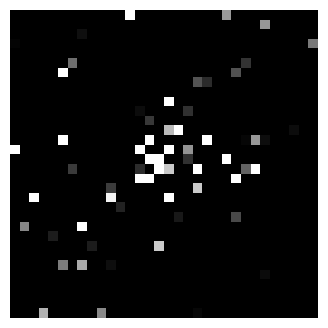

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming dataset.x contains the images and dataset.y contains the labels
# Extract the first image and label
first_image = dataset_x[0]
label = dataset_y[0]

# Plot the first image with a white background
fig, ax = plt.subplots(figsize=(4, 4))

ax.imshow(first_image, cmap='gray', vmin=0, vmax=1)  # Assuming images are normalized between 0 and 1
# ax.set_title(f'Label: {label}')
ax.axis('off')
ax.set_facecolor('white')  # Set white background

# Save the plot as an image file (e.g., PNG)
plt.savefig('first_image_plot_labelless.png')

# Show the plot
plt.show()


We can use the `trimesh` package to read and visualize the `.off` mesh files.


In [74]:
def get_point_clouds(data_2d_array):
  # Extract non-zero values and their coordinates
  non_zero_indices = np.transpose(np.nonzero(data))
  non_zero_values_with_coordinates = [(x, y, data[x, y]) for x, y in non_zero_indices]

  # Convert the list of coordinates to a NumPy array
  point_cloud = np.array(non_zero_values_with_coordinates)
  return point_cloud

# Assuming your 32x32 array is named "data"
# Replace this with your actual data
data = dataset_x[0]
point_clouds=get_point_clouds(data)

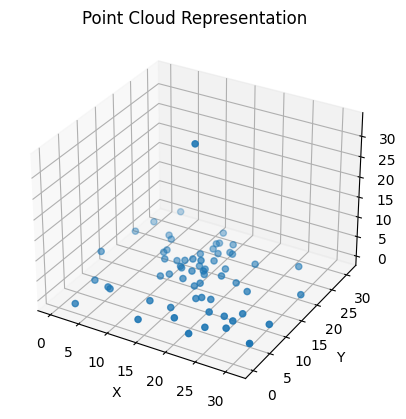

In [75]:
def show_3d_representation(point_clouds):
  import numpy as np
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  # Plot the point cloud in 3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(point_clouds[:, 0], point_clouds[:, 1], point_clouds[:, 2])

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_title('Point Cloud Representation')

  plt.show()

show_3d_representation(point_clouds)


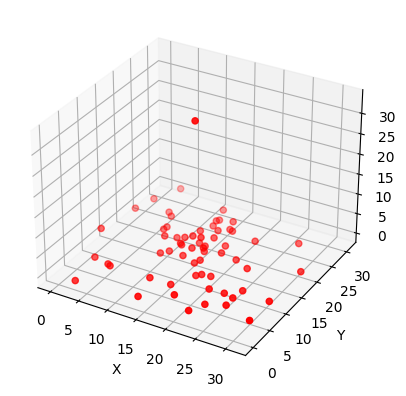

In [81]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt

# Example 3D coordinates
coordinates = point_clouds

# Creating a point cloud
point_cloud = trimesh.points.PointCloud(coordinates)

# Setting point size and color
point_size = 20
point_color = [1.0, 0.0, 0.0]  # Red color

# Extracting the points and colors
points = point_cloud.vertices
colors = np.full_like(points, point_color)

# Plotting the point cloud using Matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=point_size, c=colors)

# Set axis labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Show the plot
plt.show()


In [80]:
import trimesh
import numpy as np


# Extract the first item from the x set
first_data = dataset_x[0]

# Create a trimesh object with the point cloud
point_cloud_mesh = trimesh.points.PointCloud(point_clouds, colors=[(0,0,255,1) for x in [point_clouds]])

# Visualizing the point cloud with adjusted parameters

scene = point_cloud_mesh.scene()
scene.show()




In [88]:
import numpy as np

def get_dataset_coordinates(dataset):
    """
    Get 3D coordinates for each entry in the dataset.

    Parameters:
    - dataset: 3D array-like, the dataset containing non-zero values.

    Returns:
    - dataset_coordinates: NumPy array, each entry corresponds to the 3D coordinates of non-zero values for a particular entry in the dataset.
    """

    dataset_coordinates = []

    for data in dataset:
        # Extract non-zero values and their coordinates
        non_zero_indices = np.transpose(np.nonzero(data))
        non_zero_values_with_coordinates = [(x, y, data[x, y]) for x, y in non_zero_indices]

        # Append coordinates to the list
        dataset_coordinates.append(non_zero_values_with_coordinates)

    # Convert the list of coordinates to a NumPy array
    dataset_coordinates = np.array(dataset_coordinates, dtype=object)

    return dataset_coordinates

# Example usage:
dataset_x_coordinates = get_dataset_coordinates(dataset_x)
print("Dataset coordinates shape:", dataset_x_coordinates.shape)


Dataset coordinates shape: (1000,)


In [93]:
print(len(dataset_x_coordinates[5]))
print(dataset_x_coordinates[5])

28
[(0, 18, 0.538789), (5, 12, 0.439266), (7, 23, 0.494694), (11, 9, 0.0522914), (12, 22, 0.0848405), (13, 19, 0.544628), (14, 14, 1.244254), (14, 16, 0.177013), (14, 17, 5.36146), (14, 18, 60.65885), (14, 21, 1.27084), (15, 0, 0.0757579), (15, 16, 0.0701466), (15, 17, 2.56047), (15, 18, 6.46406), (15, 19, 4.363668), (15, 26, 0.580941), (16, 21, 3.09818), (16, 31, 0.0596124), (17, 21, 2.73927), (17, 29, 0.0165764), (19, 24, 1.43558), (21, 14, 0.612685), (22, 15, 0.230031), (26, 28, 1.5181), (28, 17, 0.0540106), (31, 23, 4.2651), (31, 28, 0.2755)]


In [ ]:
# mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
# mesh.show()


To convert a mesh file to a point cloud we first need to sample points on the mesh
surface. `.sample()` performs a unifrom random sampling. Here we sample at 2048 locations
and visualize in `matplotlib`.


In [11]:
# points = mesh.sample(2048)

# fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(111, projection="3d")
# ax.scatter(points[:, 0], points[:, 1], points[:, 2])
# ax.set_axis_off()
# plt.show()


To generate a `tf.data.Dataset()` we need to first parse through the ModelNet data
folders. Each mesh is loaded and sampled into a point cloud before being added to a
standard python list and converted to a `numpy` array. We also store the current
enumerate index value as the object label and use a dictionary to recall this later.


In [ ]:

# def parse_dataset(num_points=2048):

#     train_points = []
#     train_labels = []
#     test_points = []
#     test_labels = []
#     class_map = {}
#     folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

#     for i, folder in enumerate(folders):
#         print("processing class: {}".format(os.path.basename(folder)))
#         # store folder name with ID so we can retrieve later
#         class_map[i] = folder.split("/")[-1]
#         # gather all files
#         train_files = glob.glob(os.path.join(folder, "train/*"))
#         test_files = glob.glob(os.path.join(folder, "test/*"))

#         for f in train_files:
#             train_points.append(trimesh.load(f).sample(num_points))
#             train_labels.append(i)

#         for f in test_files:
#             test_points.append(trimesh.load(f).sample(num_points))
#             test_labels.append(i)

#     return (
#         np.array(train_points),
#         np.array(test_points),
#         np.array(train_labels),
#         np.array(test_labels),
#         class_map,
#     )



In [68]:

def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    # folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(dataset_x):
        print("processing class: {}".format(dataset_y))
        # store folder name with ID so we can retrieve later
        class_map[i] = dataset_y
        # # gather all files
        # train_files = glob.glob(os.path.join(folder, "train/*"))
        # test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in dataset_x:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        # for f in test_files:
        #     test_points.append(trimesh.load(f).sample(num_points))
        #     test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )



Set the number of points to sample and batch size and parse the dataset. This can take
~5minutes to complete.


In [69]:
NUM_POINTS = 2048
# NUM_CLASSES = 10
NUM_CLASSES = 2
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)


Streaming output truncated to the last 5000 lines.
 ['MLBT' '0.4' '2.0']
 ['MLBT' '0.4' '2.5']]
processing class: [['MLBT' '0.4' '2.5']
 ['MLBT' '0.4' '2.5']
 ['MLBT' '0.2' '2.5']
 ...
 ['MMAT' '0.3' '1']
 ['MLBT' '0.4' '2.0']
 ['MLBT' '0.4' '2.5']]
processing class: [['MLBT' '0.4' '2.5']
 ['MLBT' '0.4' '2.5']
 ['MLBT' '0.2' '2.5']
 ...
 ['MMAT' '0.3' '1']
 ['MLBT' '0.4' '2.0']
 ['MLBT' '0.4' '2.5']]
processing class: [['MLBT' '0.4' '2.5']
 ['MLBT' '0.4' '2.5']
 ['MLBT' '0.2' '2.5']
 ...
 ['MMAT' '0.3' '1']
 ['MLBT' '0.4' '2.0']
 ['MLBT' '0.4' '2.5']]
processing class: [['MLBT' '0.4' '2.5']
 ['MLBT' '0.4' '2.5']
 ['MLBT' '0.2' '2.5']
 ...
 ['MMAT' '0.3' '1']
 ['MLBT' '0.4' '2.0']
 ['MLBT' '0.4' '2.5']]
processing class: [['MLBT' '0.4' '2.5']
 ['MLBT' '0.4' '2.5']
 ['MLBT' '0.2' '2.5']
 ...
 ['MMAT' '0.3' '1']
 ['MLBT' '0.4' '2.0']
 ['MLBT' '0.4' '2.5']]
processing class: [['MLBT' '0.4' '2.5']
 ['MLBT' '0.4' '2.5']
 ['MLBT' '0.2' '2.5']
 ...
 ['MMAT' '0.3' '1']
 ['MLBT' '0.4' '2.0']
 ['

Our data can now be read into a `tf.data.Dataset()` object. We set the shuffle buffer
size to the entire size of the dataset as prior to this the data is ordered by class.
Data augmentation is important when working with point cloud data. We create a
augmentation function to jitter and shuffle the train dataset.


In [ ]:

# def augment(points, label):
#     # jitter points
#     points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
#     # shuffle points
#     points = tf.random.shuffle(points)
#     return points, label


# train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

# train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
# test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)


### Build a model

Each convolution and fully-connected layer (with exception for end layers) consits of
Convolution / Dense -> Batch Normalization -> ReLU Activation.


In [ ]:

# def conv_bn(x, filters):
#     x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
#     x = layers.BatchNormalization(momentum=0.0)(x)
#     return layers.Activation("relu")(x)


# def dense_bn(x, filters):
#     x = layers.Dense(filters)(x)
#     x = layers.BatchNormalization(momentum=0.0)(x)
#     return layers.Activation("relu")(x)



PointNet consists of two core components. The primary MLP network, and the transformer
net (T-net). The T-net aims to learn an affine transformation matrix by its own mini
network. The T-net is used twice. The first time to transform the input features (n, 3)
into a canonical representation. The second is an affine transformation for alignment in
feature space (n, 3). As per the original paper we constrain the transformation to be
close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0).


In [ ]:

# class OrthogonalRegularizer(keras.regularizers.Regularizer):
#     def __init__(self, num_features, l2reg=0.001):
#         self.num_features = num_features
#         self.l2reg = l2reg
#         self.eye = tf.eye(num_features)

#     def __call__(self, x):
#         x = tf.reshape(x, (-1, self.num_features, self.num_features))
#         xxt = tf.tensordot(x, x, axes=(2, 2))
#         xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
#         return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))



 We can then define a general function to build T-net layers.


In [ ]:

# def tnet(inputs, num_features):

#     # Initalise bias as the indentity matrix
#     bias = keras.initializers.Constant(np.eye(num_features).flatten())
#     reg = OrthogonalRegularizer(num_features)

#     x = conv_bn(inputs, 32)
#     x = conv_bn(x, 64)
#     x = conv_bn(x, 512)
#     x = layers.GlobalMaxPooling1D()(x)
#     x = dense_bn(x, 256)
#     x = dense_bn(x, 128)
#     x = layers.Dense(
#         num_features * num_features,
#         kernel_initializer="zeros",
#         bias_initializer=bias,
#         activity_regularizer=reg,
#     )(x)
#     feat_T = layers.Reshape((num_features, num_features))(x)
#     # Apply affine transformation to input features
#     return layers.Dot(axes=(2, 1))([inputs, feat_T])



The main network can be then implemented in the same manner where the t-net mini models
can be dropped in a layers in the graph. Here we replicate the network architecture
published in the original paper but with half the number of weights at each layer as we
are using the smaller 10 class ModelNet dataset.


In [ ]:
# inputs = keras.Input(shape=(NUM_POINTS, 3))

# x = tnet(inputs, 3)
# x = conv_bn(x, 32)
# x = conv_bn(x, 32)
# x = tnet(x, 32)
# x = conv_bn(x, 32)
# x = conv_bn(x, 64)
# x = conv_bn(x, 512)
# x = layers.GlobalMaxPooling1D()(x)
# x = dense_bn(x, 256)
# x = layers.Dropout(0.3)(x)
# x = dense_bn(x, 128)
# x = layers.Dropout(0.3)(x)

# outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

# model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
# model.summary()


### Train model

Once the model is defined it can be trained like any other standard classification model
using `.compile()` and `.fit()`.


In [ ]:
# model.compile(
#     loss="sparse_categorical_crossentropy",
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
#     metrics=["sparse_categorical_accuracy"],
# )

# model.fit(train_dataset, epochs=20, validation_data=test_dataset)


## Visualize predictions

We can use matplotlib to visualize our trained model performance.


In [ ]:
# data = test_dataset.take(1)

# points, labels = list(data)[0]
# points = points[:8, ...]
# labels = labels[:8, ...]

# # run test data through model
# preds = model.predict(points)
# preds = tf.math.argmax(preds, -1)

# points = points.numpy()

# # plot points with predicted class and label
# fig = plt.figure(figsize=(15, 10))
# for i in range(8):
#     ax = fig.add_subplot(2, 4, i + 1, projection="3d")
#     ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
#     ax.set_title(
#         "pred: {:}, label: {:}".format(
#             CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
#         )
#     )
#     ax.set_axis_off()
# plt.show()
